# Insurance Forecast by using Linear Regression

## Main objective

In this notebook we are going to create multiple linear regression models to try to predict the insurance fees charged by insurance companies to individuals according to some characteristics. Therefore, our goal here is prediction.

## Dataset

The dataset contains the records of more than 1,000 individuals and, besides the fees charged to each of them, we can fine several other characteristics like: Age, Sex, BMI (Body mass index), Number of children covered by health insurance / Number of dependents, Smoker/Not Smoker and region where the individual comes from.

## Data Exploration

In [63]:
#Let's import some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from scipy import stats 
from scipy.stats import chi2_contingency
from scipy.stats import norm
from scipy.stats.mstats import normaltest
import math
import warnings

warnings.filterwarnings( "ignore" )

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [64]:
#Uploading data in a DataFrame
data = pd.read_csv('/Users/lucadonghi/Desktop/IBM Machine Learning/Regression/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [65]:
#Let's start with some data exploration
data.shape

(1338, 7)

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


We note from the above info that we may need to transform some "object" data types (i.e. sex, smoker, region) into int64 with one-hot-encoding in order to perform linear regression

In [67]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


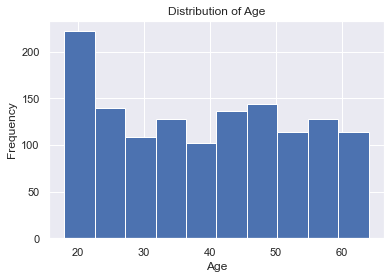

In [68]:
#Plotting a histogram of age
ax = plt.axes()
ax.hist(data['age'], bins=10);

ax.set(xlabel='Age', 
       ylabel='Frequency',
       title='Distribution of Age');

The "Age" variable distribution does not seem to be normal, so we may need to transform it using logs or other techniques.

In [69]:
normaltest(data.age.values)

NormaltestResult(statistic=1557.8205812363667, pvalue=0.0)

The test confirms that the variable "age" is not normally distributed.

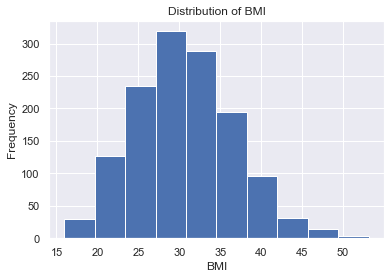

In [70]:
#Plotting a histogram of bmi
ax = plt.axes()
ax.hist(data['bmi'], bins=10);

ax.set(xlabel='BMI', 
       ylabel='Frequency',
       title='Distribution of BMI');

In [71]:
normaltest(data.bmi.values)

NormaltestResult(statistic=17.581447872784118, pvalue=0.0001521377897266011)

The same goes for BMI variable

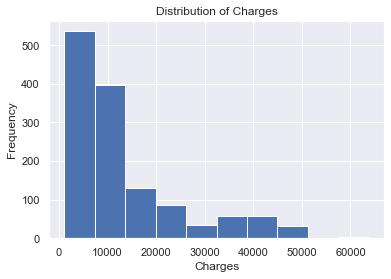

In [72]:
#Plotting a histogram of charges
ax = plt.axes()
ax.hist(data['charges'], bins=10);

ax.set(xlabel='Charges', 
       ylabel='Frequency',
       title='Distribution of Charges');

In [73]:
normaltest(data.charges.values)

NormaltestResult(statistic=336.8851220567733, pvalue=7.019807901276197e-74)

Definetely not normally distributed

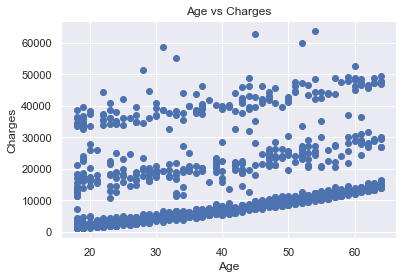

In [74]:
#Plotting a scatterplot of Charges vs Age
ax = plt.axes()
ax.scatter(data['age'], data['charges'])
ax.set(xlabel='Age',
       ylabel='Charges',
       title='Age vs Charges');

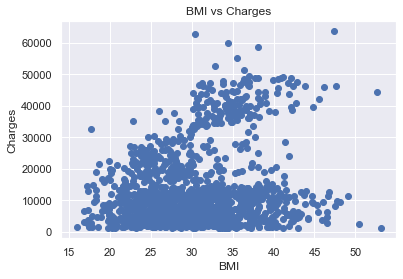

In [75]:
#Plotting a scatterplot of Charges vs Age
ax = plt.axes()
ax.scatter(data['bmi'], data['charges'])
ax.set(xlabel='BMI',
       ylabel='Charges',
       title='BMI vs Charges');

From the scatterplots above we can see that there is not a linear relationship between features and the target variable, so some transformation would be required.

In [76]:
from scipy.stats import boxcox

bc_age = boxcox(data.age)
bc_bmi = boxcox(data.bmi)
bc_charges = boxcox(data.charges)

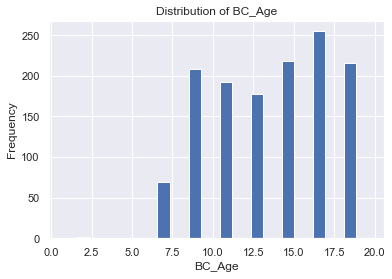

In [77]:
#Plotting a histogram of bc_age
ax = plt.axes()
ax.hist(bc_age, bins=10);

ax.set(xlabel='BC_Age', 
       ylabel='Frequency',
       title='Distribution of BC_Age');

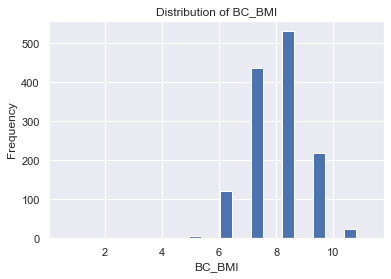

In [78]:
#Plotting a histogram of bc_bmi
ax = plt.axes()
ax.hist(bc_bmi, bins=10);

ax.set(xlabel='BC_BMI', 
       ylabel='Frequency',
       title='Distribution of BC_BMI');

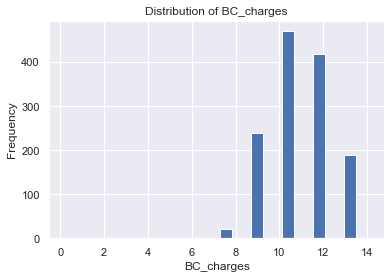

In [79]:
#Plotting a histogram of bc_charges
ax = plt.axes()
ax.hist(bc_charges, bins=10);

ax.set(xlabel='BC_charges', 
       ylabel='Frequency',
       title='Distribution of BC_charges');

## Feature Engineering

In [80]:
#Let's make a copy of the data before moving on with feature engineering
df = data.copy()

Let's one-hot-encode categorical variables

In [81]:
# Get a Pd.Series consisting of all the string categoricals
one_hot_encode_cols = df.dtypes[df.dtypes == np.object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

# Here we see another way of one-hot-encoding:
# Encode these columns as categoricals so one hot encoding works on split data (if desired)
for col in one_hot_encode_cols:
    df[col] = pd.Categorical(df[col])

# Do the one hot encoding
df = pd.get_dummies(df, columns=one_hot_encode_cols)

In [82]:
df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


## Linear Regression

In [83]:
#Generate X and y
y_col = 'charges'

X = df.drop(y_col, axis=1)
y = df[y_col]

Next, split the data in train and test data sets

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=72018)

In [85]:
s = StandardScaler()

In [86]:
X_train_ss = s.fit_transform(X_train)

In [87]:
X_test_ss = s.transform(X_test)

In [88]:
linearRegression = LinearRegression().fit(X_train_ss, y_train)

In [89]:
from sklearn.metrics import mean_squared_error

def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [90]:
linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test_ss))

print(linearRegression_rmse)

6137.488980585649


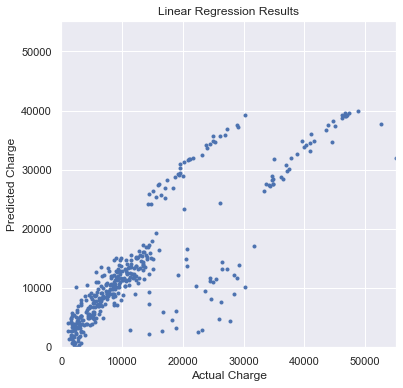

In [91]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test, linearRegression.predict(X_test_ss), 
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Charge', 
       ylabel='Predicted Charge', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

In [92]:
y_pred_s = linearRegression.predict(X_test_ss)
r2_score(y_pred_s, y_test)

0.6408275118855773

In [93]:
pd.DataFrame(zip(X.columns, linearRegression.coef_)).sort_values(by=1)

,0,1
3,sex_female,-1.043923e+17
4,sex_male,-1.043923e+17
2,children,6.033483e+02
1,bmi,2.051667e+03
0,age,3.651834e+03
5,smoker_no,4.500359e+16
6,smoker_yes,4.500359e+16
7,region_northeast,2.902820e+17
8,region_northwest,2.916031e+17
10,region_southwest,2.941790e+17


## Linear Regression with cross validation

In [94]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [95]:
#Defining an estimator
lr = LinearRegression()

estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

In [96]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

In [97]:
r2_score(y, predictions)

0.7484137440360916

## Polynomial Transformation with cross validation

In [98]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator_pf = Pipeline([("scaler", StandardScaler()), #Here we are putting scaler first, but it's generally best to place it after pf
        ("polynomial_features", PolynomialFeatures()),
        ("linear_regression", LinearRegression())])

params_pf = {
    'polynomial_features__degree': [1, 2, 3]
}

grid_pf = GridSearchCV(estimator_pf, params_pf, cv=kf)

In [99]:
grid_pf.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('linear_regression',
                                        LinearRegression())]),
             param_grid={'polynomial_features__degree': [1, 2, 3]})

In [100]:
grid_pf.best_score_, grid_pf.best_params_

(0.8342605963444788, {'polynomial_features__degree': 2})

In [101]:
y_predict_pf = grid_pf.predict(X)

In [102]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict_pf)

0.8477671718801754

In [103]:
grid_pf.best_estimator_.named_steps['linear_regression'].coef_

array([-4.36716277e+11,  3.60521179e+03,  2.01212274e+03,  9.59501849e+02,
       -1.24027114e+14, -1.28973856e+14, -3.47313509e+13,  4.91755791e+14,
        2.56399587e+14,  4.39009852e+14, -3.12836736e+14, -5.48534631e+12,
        7.81076795e+02,  5.68074809e+01, -7.78716780e+01,  3.81876755e+13,
        3.81876755e+13, -3.91516059e+13, -3.91516059e+13, -1.77082562e+14,
       -1.77268152e+14, -1.83956223e+14, -1.77268152e+14, -2.35000287e+02,
        2.09183162e+01, -6.24216038e+13, -6.24216038e+13, -3.72499673e+13,
       -3.72499673e+13,  2.32681817e+13,  2.32925677e+13,  2.41713626e+13,
        2.32925677e+13, -1.42125000e+02,  3.61426118e+12,  3.61426118e+12,
        3.84700082e+13,  3.84700082e+13, -4.25117824e+12, -4.25563365e+12,
       -4.41619256e+12, -4.25563365e+12, -8.08529318e+13,  7.89072338e+13,
       -1.52241397e+14, -2.31683037e+13,  1.54783327e+14,  9.77499698e+13,
       -4.00490846e+14, -4.81784705e+13, -7.66104656e+13, -2.53301012e+14,
       -1.24227919e+14,  

In [104]:
pd.DataFrame(zip(X.columns, grid_pf.best_estimator_.named_steps['linear_regression'].coef_)).sort_values(by=1)

,0,1
10,region_southwest,-3.128367e+14
5,smoker_no,-1.289739e+14
4,sex_male,-1.240271e+14
6,smoker_yes,-3.473135e+13
0,age,-4.367163e+11
3,sex_female,9.595018e+02
2,children,2.012123e+03
1,bmi,3.605212e+03
8,region_northwest,2.563996e+14
9,region_southeast,4.390099e+14


## Ridge Regression with cross validation

In [105]:
# Same estimator as before
estimator_rr = Pipeline([("scaler", StandardScaler()), #Here we are putting scaler first, but it's generally best to place it after pf
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params_rr = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid_rr = GridSearchCV(estimator_rr, params_rr, cv=kf)

In [106]:
grid_rr.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [107]:
grid_rr.best_score_, grid_rr.best_params_

(0.834510584582958,
 {'polynomial_features__degree': 2, 'ridge_regression__alpha': 20.0})

In [108]:
y_predict_rr = grid_rr.predict(X)

In [109]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict_rr)

0.8477297622470372

In [110]:
grid_rr.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00,  3.55242915e+03,  1.98524920e+03,  9.33289800e+02,
        1.21076879e+02, -1.21076879e+02, -1.14321926e+03,  1.14321926e+03,
        1.06873191e+02,  1.04853113e+01, -4.10329318e+01, -7.46655667e+01,
        7.62816538e+02,  5.81733169e+01, -8.90551414e+01, -6.35327752e+01,
        6.35327752e+01,  1.34734770e+01, -1.34734770e+01, -1.75609703e+02,
       -7.01783748e+01,  1.44248215e+02,  9.59137321e+01, -2.32497853e+02,
        2.43101983e+01, -1.07445935e+01,  1.07445935e+01, -1.80223449e+03,
        1.80223449e+03,  1.52070030e+02,  1.12264016e+02, -2.11226023e+02,
       -4.49795609e+01, -1.31664271e+02,  6.60037161e+01, -6.60037161e+01,
        9.29921051e+01, -9.29921051e+01,  5.03444678e+01,  1.75270284e+02,
       -6.53376904e+01, -1.57759257e+02,  2.53388505e+00, -2.53388505e+00,
       -2.12550535e+00,  2.12550535e+00,  3.92881010e+01, -4.37560634e+00,
       -3.90943417e+01,  5.69795251e+00,  2.53388505e+00,  2.12550535e+00,
       -2.12550535e+00, -

In [111]:
pd.DataFrame(zip(X.columns, grid_rr.best_estimator_.named_steps['ridge_regression'].coef_)).sort_values(by=1)

,0,1
6,smoker_yes,-1143.219257
5,smoker_no,-121.076879
10,region_southwest,-41.032932
0,age,0.000000
9,region_southeast,10.485311
8,region_northwest,106.873191
4,sex_male,121.076879
3,sex_female,933.289800
7,region_northeast,1143.219257
2,children,1985.249203


## Lasso Regression with cross validation

In [112]:
# Same estimator as before
estimator_las = Pipeline([("scaler", StandardScaler()), #Here we are putting scaler first, but it's generally best to place it after pf
        ("polynomial_features", PolynomialFeatures()),
        ("lasso_regression", Lasso(max_iter=10000))])

params_las = {
    'polynomial_features__degree': [1, 2, 3],
    'lasso_regression__alpha': np.geomspace(0.06, 6.0, 20)
}

grid_las = GridSearchCV(estimator_las, params_las, cv=kf)

In [113]:
grid_las.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('lasso_regression',
                                        Lasso(max_iter=10000))]),
             param_grid={'lasso_regression__alpha': array([0.06      , 0.0764565 , 0.0974266 , 0.12414828, 0.15819905,
       0.2015891 , 0.25687994, 0.32733569, 0.41711568, 0.53152007,
       0.67730274, 0.86306993, 1.09978843, 1.40143288, 1.78581086,
       2.27561411, 2.89975814, 3.69508927, 4.70855982, 6.        ]),
                         'polynomial_features__degree': [1, 2, 3]})

In [114]:
grid_las.best_score_, grid_las.best_params_

(0.8345974235102429,
 {'lasso_regression__alpha': 6.0, 'polynomial_features__degree': 2})

In [115]:
y_predict_las = grid_las.predict(X)

In [116]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict_las)

0.8477559024215673

In [117]:
grid_las.best_estimator_.named_steps['lasso_regression'].coef_

array([ 0.00000000e+00,  3.60341598e+03,  2.00241594e+03,  9.40415733e+02,
        2.39467183e+02, -4.07845158e-15, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        7.67873266e+02,  5.42932885e+01, -6.79450907e+01, -1.23166040e+02,
        5.44026947e-15,  2.11939708e+01, -1.37917508e-15, -2.62937116e+02,
       -1.57493834e+02,  4.78361782e+01,  0.00000000e+00, -2.32199231e+02,
        1.14803596e+01, -1.42928536e+01,  5.16303761e-11, -3.62572029e+03,
        0.00000000e+00,  1.86080980e+02,  1.50112898e+02, -1.69593515e+02,
       -0.00000000e+00, -1.32912559e+02,  1.25806397e+02, -4.22441170e-12,
        1.81954078e+02, -0.00000000e+00,  1.04859246e+02,  2.28997456e+02,
       -0.00000000e+00, -9.54347396e+01,  0.00000000e+00, -0.00000000e+00,
       -4.22478114e+00,  3.89671988e-12,  7.76194851e+01, -0.00000000e+00,
       -6.80532464e+01,  1.08925706e+01,  0.00000000e+00,  3.07889164e+00,
       -4.32709978e-12, -

In [118]:
pd.DataFrame(zip(X.columns, grid_las.best_estimator_.named_steps['lasso_regression'].coef_)).sort_values(by=1)

,0,1
5,smoker_no,-4.078452e-15
0,age,0.000000e+00
6,smoker_yes,-0.000000e+00
7,region_northeast,0.000000e+00
8,region_northwest,0.000000e+00
9,region_southeast,0.000000e+00
10,region_southwest,-0.000000e+00
4,sex_male,2.394672e+02
3,sex_female,9.404157e+02
2,children,2.002416e+03


## Visual comparison

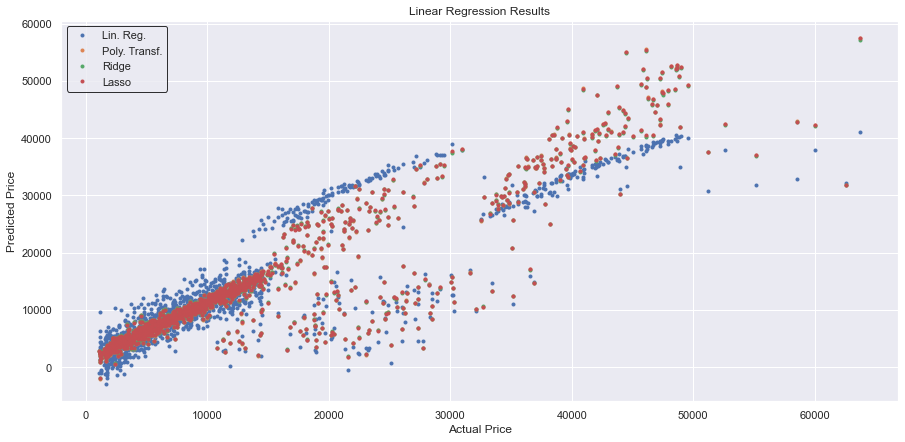

In [119]:
f = plt.figure(figsize=(15,7))
ax = plt.axes()

labels = ['Lin. Reg.', 'Poly. Transf.', 'Ridge', 'Lasso']
models = [predictions, y_predict_pf ,y_predict_rr, y_predict_las]

for mod, lab in zip(models, labels):
    ax.plot(y, mod, 
             marker='o', ls='', ms=3.0, label=lab)


leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       title='Linear Regression Results');